# Estudo de caso 2: Precificação de derivativos


In [40]:
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    ElasticNet
)

from sklearn.tree      import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm       import SVR

from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor
)

from sklearn.neural_network import MLPRegressor

# Para analise de dados e a avaliacao de modelos
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)

from sklearn.feature_selection import (
    SelectKBest,
    chi2, f_regression
)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# RNA
import tensorflow as tf
import keras

In [41]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
import yfinance as yf


## O que é?
Precificação de derivativos é o processo de determinar o valor de um derivativo. Um derivativo é um instrumento financeiro cujo valor é baseado no valor de outro ativo, como uma ação, uma commodity ou uma taxa de juros. A precificação de derivativos envolve a avaliação do valor do ativo subjacente e a determinação do valor do derivativo com base nessa avaliação.
> é o processo de determinar o valor justo de um contrato derivativo — ou seja, de um ativo financeiro cujo valor depende do preço de outro ativo (ativo subjacente), como ações, moedas, commodities ou taxas de juros.

Exemplo: no caso de uma opção de compra (call) de ações, a precificação pode ser feita usando o modelo Black-Scholes, que considera fatores como preço atual da ação, preço de exercício, tempo até o vencimento, taxa de juros livre de risco e volatilidade esperada.

Assim, se a ação da empresa X vale R$ 50 e a opção dá o direito de comprá-la por R$ 48 daqui a um mês, o modelo ajuda a estimar quanto essa opção deveria custar hoje no mercado.

### Definindo o problema

Para esse problema a target é o preço da opção, eas features são os dados do mercados usados como entradas no modelo de black-scholes de precificação de opções.
> As features para estimas o preço do mercadi da opção são o preço da ação, preço de exercicio(strike price), tempo de vencimento, volatilidade, taxa de juros e dividend yiel
> Exemplo abaixo:

1. **Preço da ação (Spot Price)** – valor atual de mercado da ação no momento da precificação.

   * *Ex.:* A ação da empresa X está sendo negociada a **R\$ 50** hoje.

2. **Preço de exercício (Strike Price)** – valor pré-definido no contrato para comprar ou vender o ativo no futuro.

   * *Ex.:* Uma opção de compra pode ter strike de **R\$ 48**, ou seja, garante o direito de comprar a ação por R\$ 48 na data de vencimento.

3. **Tempo até o vencimento (Time to Maturity)** – intervalo de tempo restante até a data de expiração do derivativo.

   * *Ex.:* Faltam **30 dias** para a opção expirar.

4. **Volatilidade (Volatility)** – medida da variação esperada do preço do ativo ao longo do tempo; quanto maior, mais incerto e arriscado é o preço futuro.

   * *Ex.:* Uma volatilidade anual de **20%** indica que o preço pode variar em média ±20% ao ano.

5. **Taxa de juros livre de risco (Risk-free Rate)** – retorno teórico de um investimento sem risco de crédito, usado como referência na precificação.

   * *Ex.:* Taxa SELIC ou yield de títulos do governo, como **10% ao ano**.

6. **Dividend Yield** – percentual do valor da ação que a empresa distribui em dividendos em relação ao seu preço de mercado.

   * *Ex.:* Se a ação custa **R\$ 50** e paga **R\$ 2,50** em dividendos por ano, o dividend yield é **5%**.



$$
e^{-q\pi} O(\frac{-\ln{M} + (r + \frac{\sigma^2}{2})\pi}{\sigma\sqrt{\pi}}) - e^{r\pi} M O(\frac{\ln{M} + (r - \frac{\sigma^2}{2})\pi}{\sigma\sqrt{\pi}})
$$

É comun derivarmos a volatilidade a partir do preço das ações existentes no mercardo, e tal volatilidade é referida como implicita. Nesse exercicio presumimos que a estratura da superficie da volatilidade, em que a volatilidade depende de moneyness da opçao edo etempo para o vencimento para gerar a superficie da volatilidade da opção.

$$
\sigma(M,\pi) = \sigma{_0} + \alpha\pi + \beta(M-1)^2
$$

In [42]:
true_alpha   = 0.1
true_beta    = 0.1
true_sigma_0 = 0.2

In [43]:
# Taxa livre de risco
risk_free_rate = 0.05

Volatilidade e funções de preficição de opções

In [44]:
def option_vol_from_surface(moneyness, tempo_de_vencimento):
    return (
        true_sigma_0 + true_alpha *tempo_de_vencimento + true_beta * np.square(moneyness - 1)
    )

In [45]:
import scipy.stats as stats
def call_option_price(moneyness, tempo_de_vencimento, option_vol):

    d1 = (
        np.log(1/moneyness) + risk_free_rate + np.square(option_vol) * tempo_de_vencimento
    )/(option_vol * np.sqrt(tempo_de_vencimento))

    d2 = (
        np.log(1/moneyness) + risk_free_rate - np.square(option_vol) * tempo_de_vencimento
    )/(option_vol * np.sqrt(tempo_de_vencimento))

    norm_d1 = stats.norm.cdf(d1)
    norm_d2 = stats.norm.cdf(d2)

    return (
        norm_d1 - moneyness * np.exp(-risk_free_rate * tempo_de_vencimento) * norm_d2
    )

`Geração de dados`

In [46]:
N  = 10_000
Ks = 1 + 0.25 * np.random.randn(N)
T  = np.random.random(N)

In [47]:
Sigmas = np.array(
    [
        option_vol_from_surface(moneyness, tempo_de_vencimento)
        for moneyness, tempo_de_vencimento in zip(Ks, T)
    ]
)

Ps = np.array([
    call_option_price(moneyness, tempo_de_vencimento, option_vol)
    for moneyness, tempo_de_vencimento, option_vol in zip(Ks, T, Sigmas)
])

Criando target e feature

In [48]:
Y = Ps
X = np.concatenate([Ks.reshape(-1, 1), T.reshape(-1, 1), Sigmas.reshape(-1, 1)], axis=1)

In [49]:
data = pd.DataFrame(
    np.concatenate([Y.reshape(-1, 1), X], axis=1),
    columns=['Preço da opção', 'Moneyness', 'Tempo de Vencimento', 'Volatilidade']
)

In [50]:
data.head(2)

,Preço da opção,Moneyness,Tempo de Vencimento,Volatilidade
0,0.285961,0.897708,0.964914,0.297538
1,0.218353,0.870030,0.572112,0.258900


#### Visualização

In [51]:
data.describe()

,Preço da opção,Moneyness,Tempo de Vencimento,Volatilidade
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.180006,0.994685,0.498597,0.256165
std,0.136645,0.251057,0.290133,0.030297
min,-0.021299,0.031541,0.000023,0.200093
25%,0.075263,0.826549,0.247999,0.230802
50%,0.160482,0.996443,0.496746,0.256350
75%,0.252343,1.163824,0.747572,0.281300
max,0.969074,1.920604,0.999886,0.379770


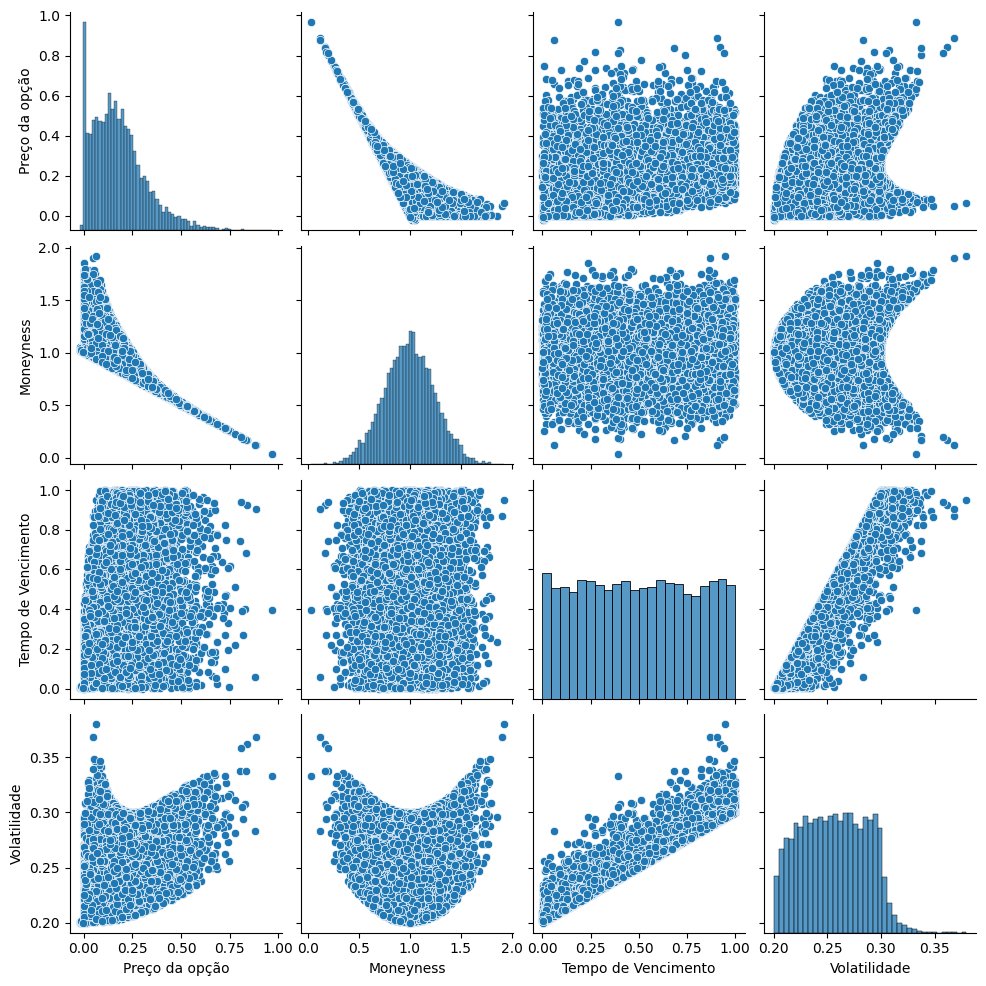

In [52]:
sns.pairplot(data=data, diag_kind='hist')
plt.show()

Seleção de caracteristicas

In [53]:
best_features = SelectKBest(k='all', score_func=f_regression)
fit = best_features.fit(X, Y)

In [60]:
data.columns.tolist()

['Preço da opção', 'Moneyness', 'Tempo de Vencimento', 'Volatilidade']

In [59]:
fit.scores_

array([28752.58008459,  1477.74035593,  2496.69365128])

In [57]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data.columns.tolist()[1:])
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

In [58]:
featureScores.nlargest(10, 'Score')

,Specs,Score
0,Moneyness,28752.580085
2,Volatilidade,2496.693651
1,Tempo de Vencimento,1477.740356


Kfold

In [66]:
kfolds = 5
score = 'neg_mean_squared_error'

In [67]:
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))

xtrain, xtest = X[:train_size], X[train_size:]
ytrain, ytest = Y[:train_size], Y[train_size:]

In [68]:
models = []

models.append(('LinearRegression', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('KNeighbors', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))
models.append(('ExtraTrees', ExtraTreesRegressor()))
models.append(('AdaBoost', AdaBoostRegressor()))
models.append(('MLP', MLPRegressor()))

In [69]:
names, kfold_scores, test_results, train_results = [], [], [], []

for name, model in models:
    names.append(name)

    kfold = KFold(n_splits=kfolds, shuffle=True, random_state=12)

    cv_results = cross_val_score(model, xtrain, ytrain, cv=kfold, scoring=score)
    kfold_scores.append(cv_results)
    
    res = model.fit(xtrain, ytrain)
    train_results.append(mean_squared_error(ytrain, res.predict(xtrain)))
    test_results.append(mean_squared_error(ytest, res.predict(xtest)))

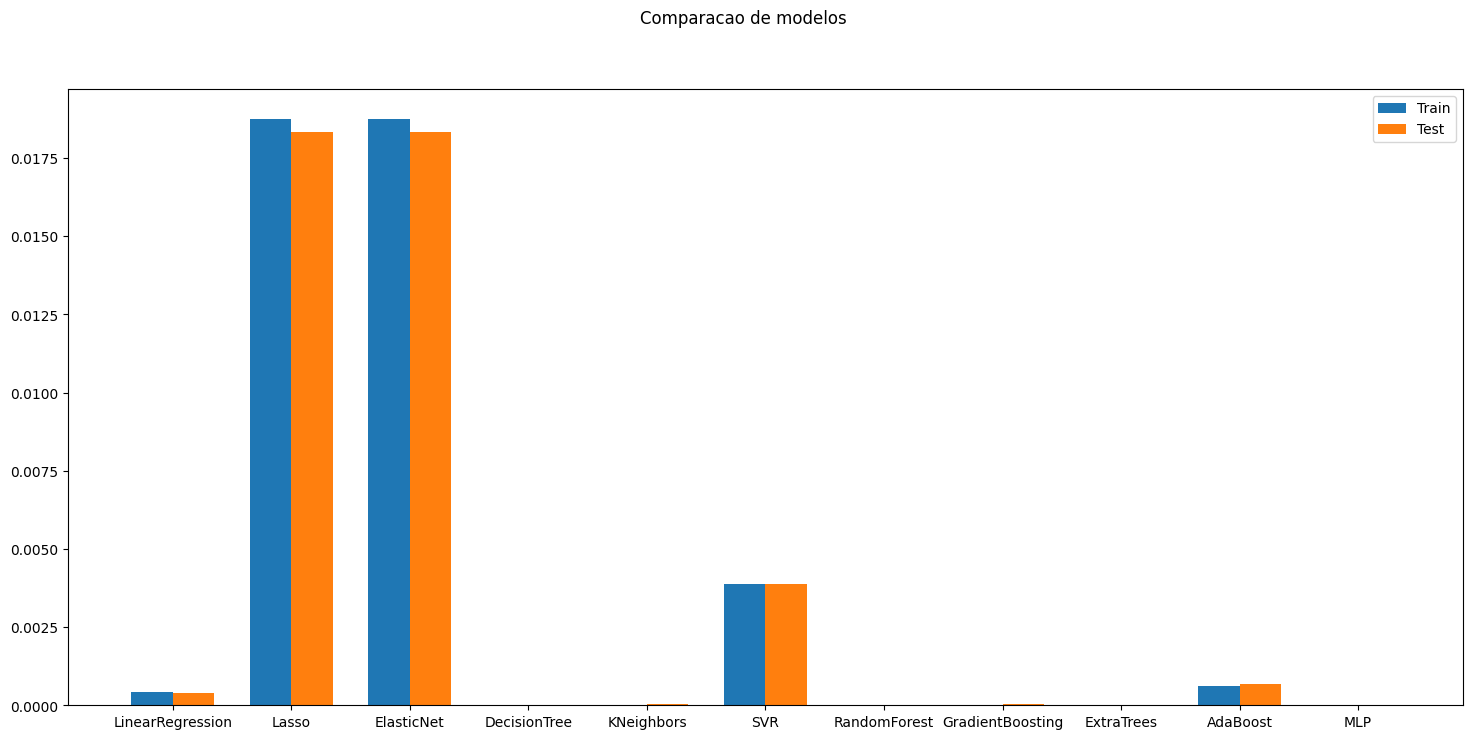

In [70]:
fig = plt.figure(figsize=(18,8))
fig.suptitle('Comparacao de modelos')
ax  = fig.add_subplot(111)

ind = np.arange(len(names))
width = 0.35

plt.bar(ind, train_results, width, label='Train')
plt.bar(ind + width, test_results, width, label='Test')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(names)
plt.legend()
plt.show()

Redes neurais podem ser efetiva em situações complexas de precificação de derivativos

In [73]:
from functools import partial

In [83]:
Dense_ = partial(
    keras.layers.Dense,
    activation=keras.activations.elu,
    kernel_initializer=keras.initializers.he_normal(),
)

In [95]:
model = keras.models.Sequential([
    Dense_(64),
    Dense_(32),
    Dense_(16),
    Dense_(8),
    Dense_(4),
    keras.layers.Dense(1)
])
model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    metrics=[keras.metrics.mean_squared_error]
)

history = model.fit(
    xtrain, ytrain,
    epochs=30,
    validation_data=(xtest, ytest),
    verbose=0
)

<Axes: >

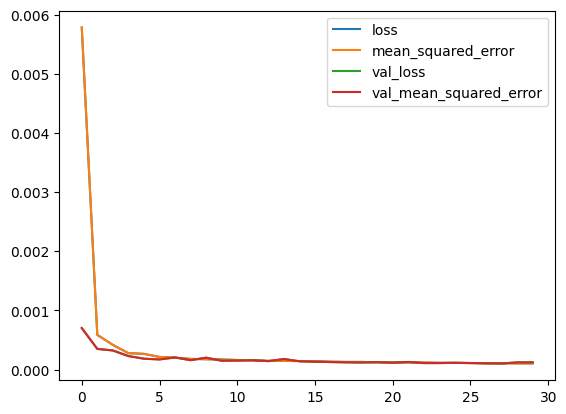

In [96]:
pd.DataFrame(history.history).plot()

In [98]:
mean_squared_error(ytest, model.predict(xtest, verbose=0))

0.00012226789343859105

MLP

In [101]:
params = {
    'hidden_layer_sizes':[        
        (20,),
        (50,),
        (20, 20),
        (20, 30, 20)
    ]
}

kfold = KFold(n_splits=5)
grid = GridSearchCV(MLPRegressor(), params, cv=kfold, scoring=score)
grid.fit(xtrain, ytrain)
grid.best_params_

{'hidden_layer_sizes': (20, 30, 20)}

In [102]:
grid.best_score_

np.float64(-2.5735057709405434e-05)

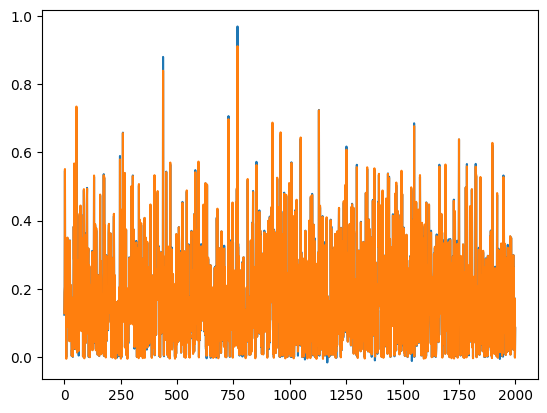

In [108]:
plt.plot(range(len(xtest)), ytest)
plt.plot(range(len(xtest)), grid.predict(xtest))